In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC Dataset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [2]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


sys.path.insert(0, "../")
# import utils.utils_feature_selection as fs
# import utils.utils_evaluation as e
# import utils.utils_figures as f
import utils.settings as s
# import utils.utils_processing as pp

s.init()
seed = s.seed
pd.set_option('display.max_columns', None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]

In [3]:
data = pd.read_excel(f"../input_survey_data/final_data_{target.split('_',1)[-1].rsplit('_',1)[0]}_tueb.xlsx")
#df_candidates = pd.read_excel("..//input_survey_data/input_data_businessreduction_tueb.xlsx")

print(data.shape)
data.tail(2)

(324, 24)


,Target_relative_contentloss_euro,Target_relative_contentloss_euro.1,shp_registered_capital_euro,flowvelocity,shp_employees,shp_avgmonthly_sale_cat,bage,water_barriers_impl,b_area,pumping_equipment_impl,water_depth_cm,hh_monthly_income_cat,inundation_duration_h,resistant_material_building_impl,flood_experience,emergency_measures.2,protect_valuables_impl,elevation_building_impl,shp_sector,emergency_measures.4,contaminations.0,emergency_measures.7,shp_owner,electricity_higher_impl
322,0.0,0.0,3682.6,2,2,2,1.0,1,80.0,5,40,3.0,5.0,5,6,1,1,4,11,1,0,1,3,5
323,0.0,0.0,3682.6,3,2,3,30.0,1,60.0,1,60,4.0,4.0,5,6,1,2,2,11,1,0,1,1,1


In [4]:
data = data.drop("Target_relative_contentloss_euro.1", axis = 1)
data = data.drop("bage", axis = 1) # drop, due to high negative correlation to b_area / hh_monthly _income / hp_avgmonthly_sale

In [5]:
## TEST before using weights from Log Reg, 

data = data.loc[data[f"{target}"]>0, :]


In [6]:
# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f'bn_{target}'

# Select the columns to use in the NPBN
columns_used=range(0, 11) # use currnetly 10 most important features + target for BN
data = data.iloc[:,columns_used] 

# Extract the variable names
names_list = tuple(data.columns)
names = {k: i for i, k in enumerate(names_list)}
print("Using following features:", names)

# mylist.remove(targetvalue)
# mylist.insert(0, targetvalue)
# shp_sector, emploees, reg_capital, avgmon_sale, mon_income
# flovelo, w_depth, contamam 0, inund_h
# flood_exp, emergy_2, water_bar_impl, pump_eq_impl, protect_valuabl_impl, resistant_m_b_impl, elec_higher_impl
# overall_building_problm, b_area, 

Using following features: {'Target_relative_contentloss_euro': 0, 'shp_registered_capital_euro': 1, 'flowvelocity': 2, 'shp_employees': 3, 'shp_avgmonthly_sale_cat': 4, 'water_barriers_impl': 5, 'b_area': 6, 'pumping_equipment_impl': 7, 'water_depth_cm': 8, 'hh_monthly_income_cat': 9, 'inundation_duration_h': 10}


In [7]:
# Extract number of nodes from data
N = data.shape[1]  # number of nodes == number of features + target

# Defining the structure of the BN
parent_cell = [None]*N


parent_cell[0] = [1,2,3,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
parent_cell[1] = []                                                                     #   shp_registered_capital_euro
parent_cell[2] = [names["water_depth_cm"], names["inundation_duration_h"]]              #   flowvelo (parent nodes: water_depth_cm) 
# not hydro <- building properties
parent_cell[3] = [names["shp_avgmonthly_sale_cat"]]                                     #   shp_employees (parent node: shp_avgmonthly_sale_cat)   
parent_cell[4] = [names["shp_registered_capital_euro"]]                                 #   shp_avgmonthly_sale_cat (parent node: shp_registered_capital_euro)
parent_cell[5] = [names["shp_registered_capital_euro"], names["water_depth_cm"]]        #   water_barriers_impl   (parent: shp_registered_capital_euro) or dependence on water_depth ?
parent_cell[6] = [names["shp_registered_capital_euro"]]                                 #   b_area (parent nodes: shp_registered_capital_euro)
parent_cell[6] = [names["shp_registered_capital_euro"]]                                 #   B_age (parent nodes: shp_registered_capital_euro)
parent_cell[7] = [names["shp_avgmonthly_sale_cat"]] # , names["water_depth_cm"]]        #   pumping_equipment_impl  (parent:  shp_registered_capital_euro) or dependence on water_depth ?
parent_cell[8] = []                                                                     #   water_depth_cm 
parent_cell[9] =  [names["shp_avgmonthly_sale_cat"]]                                    #   hh_monthly_income_cat (parent node: shp_avgmonthly_sale_cat)   
parent_cell[10] = []                                                                    #   inundation_duration_h


## chec spearman correlations of feautres: eg. b_area (evtl as standalone feature)

## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target




In [8]:
parent_cell

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [],
 [8, 10],
 [4],
 [1],
 [1, 8],
 [1],
 [4],
 [],
 [4],
 []]

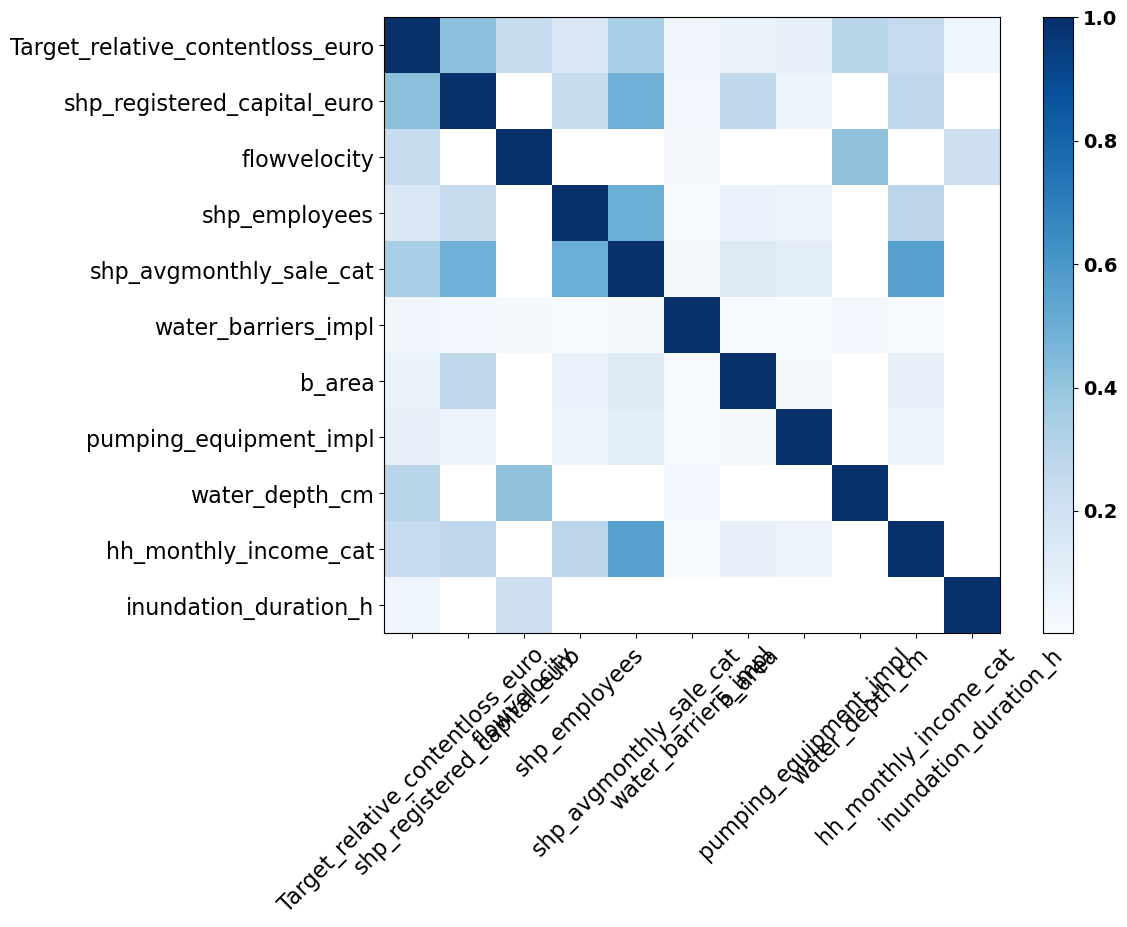

In [9]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

# TODO add coef values in cells
# TODO fix x -label shift
R = bn_rankcorr(parent_cell,        # structure of the BN
                data,               # matrix of data
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don't create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.


In [10]:
# #-----------------------------------------------------------------------------
# # Function 2 - bn_visualize - Plot of the Bayesian Network
# #-----------------------------------------------------------------------------

# bn_visualize(parent_cell,           # structure of the BN
#              R,                     # the rank correlation matrix (function 1)
#              data.columns,          # names of variables
#              fig_name = fig_name)   # figure name
# # The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# # rank correlations indicated on the arcs.

# bn_visualize(parent_cell,                       # structure of the BN
#              R,                                 # the rank correlation matrix 
#              data.columns,                      # names of variables
#              data = data,                       # DataFrame with data
#              fig_name = fig_name + '_margins')  # figure name
# # The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# # rank correlations indicated on the arcs. In this plot also the marginal
# # distributions for each variable are incorporated.


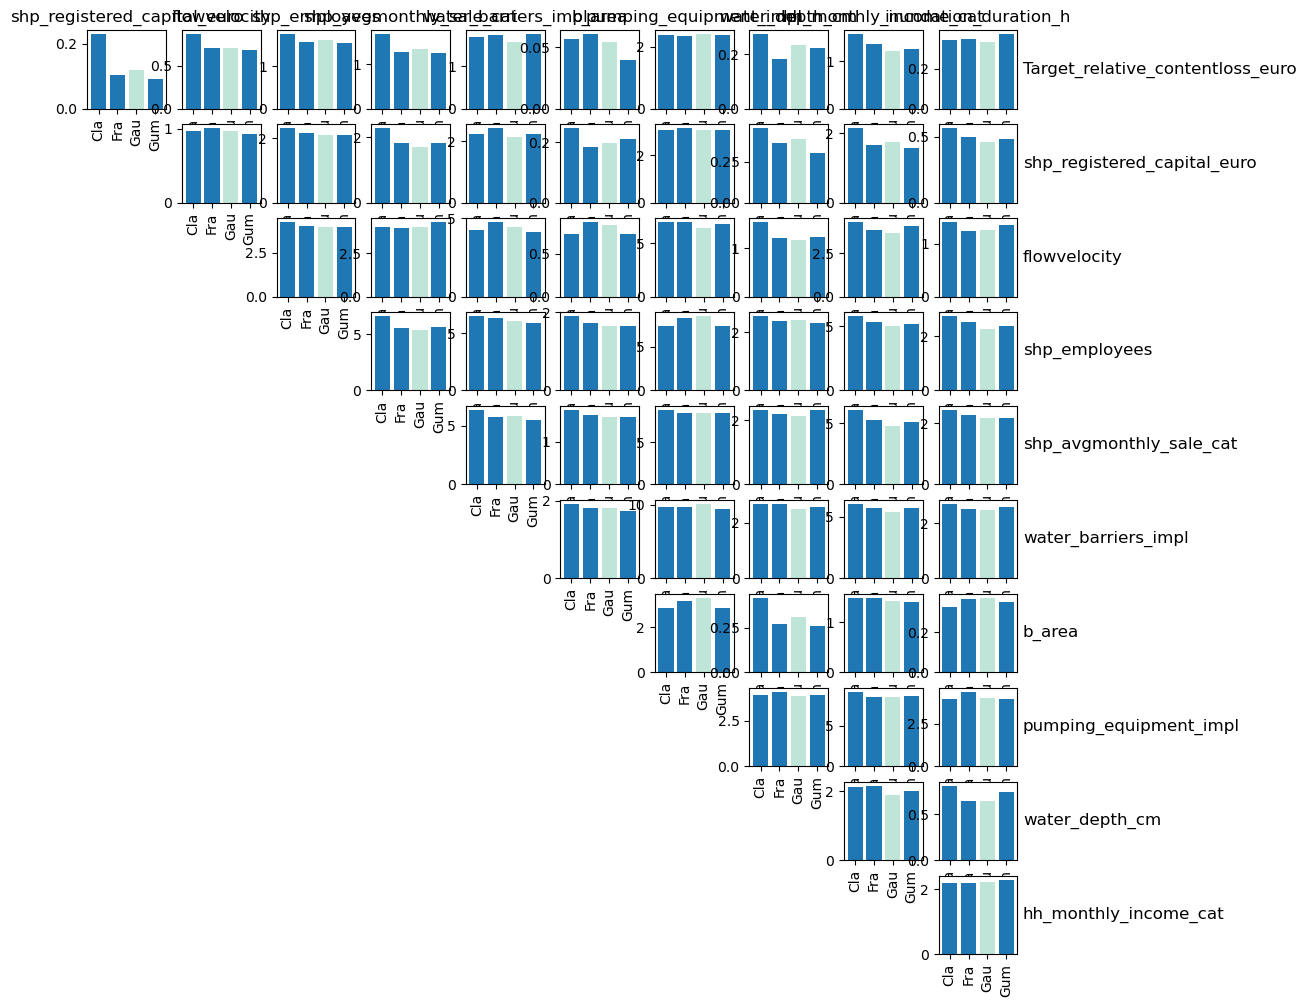

In [11]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(data,                   # DataFrame with data
                  names = data.columns,   # names of variables
                  plot = True,               # create a plot (0=don't create plot)
                  fig_name = fig_name)    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

In [12]:
M

,Var1,Var2,r,Clayton,Frank,Gaussian,Gumbel
0,Target_relative_contentloss_euro,shp_registered_capital_euro,0.477281,0.230145,0.104219,0.119504,0.090601
1,Target_relative_contentloss_euro,flowvelocity,0.246131,0.866363,0.699953,0.706759,0.67644
2,Target_relative_contentloss_euro,shp_employees,0.199736,1.752971,1.570679,1.604414,1.530893
3,Target_relative_contentloss_euro,shp_avgmonthly_sale_cat,0.387933,1.681167,1.268319,1.339234,1.253051
4,Target_relative_contentloss_euro,water_barriers_impl,0.039294,1.673268,1.734771,1.574327,1.754472
5,Target_relative_contentloss_euro,b_area,0.089371,0.056663,0.06058,0.054028,0.039763
6,Target_relative_contentloss_euro,pumping_equipment_impl,0.116703,2.391384,2.35063,2.411693,2.391394
7,Target_relative_contentloss_euro,water_depth_cm,0.409312,0.273067,0.182509,0.231714,0.222512
8,Target_relative_contentloss_euro,hh_monthly_income_cat,0.228397,1.573769,1.358005,1.208059,1.260667
9,Target_relative_contentloss_euro,inundation_duration_h,0.204652,0.340874,0.349649,0.333295,0.372687


In [1]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() in d_cal.py from py_banshee package ~ 1h
## try to fix, otherwise write with CC Dominik (maybe mixed up respective matlab func()--> )
#?np.matmul() 

## gaussian_distance : validation: 
# D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
#                             R,        # the rank correlation matrix 
#                             data,     # DataFrame with data
#                             4000,     # number of samples drawn d-Cal(ERC,NRC)
#                             400,      # number of samples drawn d-Cal(NRC,BNRC)
#                             1000,     # number of iterations to compute CI
#                             Plot=True,          # create a plot (0=don't create plot)
#                             Type='H',           # take Hellinger distance (default)
#                             fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN's rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large datasets.


Object `np.matmul()` not found.


In [19]:
data.head(2)#.shape

,Target_relative_contentloss_euro,shp_registered_capital_euro,flowvelocity,shp_employees,shp_avgmonthly_sale_cat,water_barriers_impl,b_area,pumping_equipment_impl,water_depth_cm,hh_monthly_income_cat,inundation_duration_h
7,0.002289,3682.6,2,2,4,5,54.0,5,20,7.0,12.0
9,0.001999,441.9,4,2,1,1,45.0,5,3,3.0,2.0


In [20]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = data.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              data,             # DataFrame with data
              Output='mean')    # type of output data



Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  1%
Making inference. Progress:  2%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  4%
Making inference. Progress:  5%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  7%
Making inference. Progress:  8%
Making inference. Progress:  9%
Making inference. Progress:  9%
Making inference. Progress:  10%
Making inference. Progress:  11%
Making inference. Progress:  12%
Making inference. Progress:  12%
Making inference. Progress:  13%
Making inference. Progress:  14%
Making inference. Progress:  15%
Making inference. Progress:  15%
Making inference. Progress:  16%
Making inference. Progress:  17%
Making inference. Progress:  18%
Making inference. Progress:  18%
Making inference. Progress:  19%
Making inference. Progress:  20%
Making inference. Progress:  21%
Making inference. Progress:  21%
Making inference. Progre

## Evaluation

In [25]:
## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_original=data.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_original - y_original.mean(axis=0))/y_original.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_original))
MBE = np.mean(y_pred-y_original)
RMSE = (np.mean((y_pred-y_original)**2))**(1/2)



In [27]:
print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  

# first try: MAE, MBE, RMSE, R2: 0.22737828120590867 0.18693083465146496 0.4326010916688961 1.055515193816181e-05
# -> moderate overestimation of BN model, stronger overall 


# The coefficient of determination between modelled and observed target 
# is xxx, but the average error (mae: 0.227) is much higher than
# the average value of the response (mean: 0.056), and there is some overestimation bias.
# However, for proper validation, if sufficient data is available, a split-
# -sample validation or a k-fold cross-validation should be performed.

## see how small BN performs than expanded by further variables and check performance


####################################################

## set up folder and file permissions recurvesively

############ python meeting #############
## PDP
## google colab #  r - py combine :  
## y_pred , permutation -which fetures/or one feature
## pytorch, keras <-->  R, 
## explore() compare two maps- zomm in --> linked maps

MAE, MBE, RMSE, R2: 0.22737828120590867 0.18693083465146496 0.4326010916688961 1.055515193816181e-05


In [41]:
#?RepeatedKFold

In [39]:
# from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict


# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)

# scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
#     F, 
#     data.iloc[:,condition], y_original, 
#     # return_train_score=  # if True: more computanitonal expensive, gives scores of training sets
#     scoring="neg_MAE",# "neg_mean_absolute_error",,  # Strategy to evaluate the performance of the cross-validated model on the test set.
#     cv=cv, 
#     n_jobs=-1
# ) 


InvalidParameterError: The 'estimator' parameter of cross_validate must be an object implementing 'fit'. Got array([[ 0.16347476],
       [ 0.01371408],
       [ 0.01816009],
       [ 0.16722744],
       [ 1.1       ],
       [ 0.10879648],
       [ 0.05607578],
       [ 0.05824835],
       [ 0.05476475],
       [ 0.02918989],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 0.39124636],
       [ 0.11123776],
       [ 1.1       ],
       [-0.00326076],
       [ 0.07375042],
       [ 0.00628686],
       [ 0.03791784],
       [ 0.09739452],
       [ 0.02054741],
       [ 0.09661246],
       [ 0.14391711],
       [ 0.14089535],
       [ 1.1       ],
       [ 0.10328404],
       [ 0.39148823],
       [ 1.1       ],
       [ 0.07732154],
       [ 0.07326568],
       [ 0.36064486],
       [ 0.04081759],
       [ 0.02596857],
       [ 0.02815278],
       [ 0.05071997],
       [ 1.1       ],
       [ 0.04151131],
       [ 0.18314016],
       [ 0.0260848 ],
       [ 0.04534307],
       [ 0.02867887],
       [ 0.14498903],
       [ 0.05158406],
       [ 0.0069605 ],
       [ 0.09133098],
       [ 0.35257486],
       [ 0.21644883],
       [ 0.48579645],
       [ 0.11176638],
       [ 0.0123673 ],
       [ 1.1       ],
       [ 0.10776571],
       [ 0.06499087],
       [ 0.02842233],
       [ 0.01551382],
       [ 0.04945894],
       [ 0.13813305],
       [ 0.02489687],
       [ 0.07140658],
       [ 0.1064993 ],
       [ 0.093665  ],
       [ 0.01560742],
       [ 0.01974605],
       [ 0.00119183],
       [ 0.33555809],
       [ 0.13194573],
       [ 0.14211835],
       [ 1.1       ],
       [ 0.03241035],
       [ 0.03332841],
       [ 0.02512826],
       [ 0.04624671],
       [ 0.15451778],
       [ 0.02223136],
       [ 1.1       ],
       [ 0.04054287],
       [ 0.04385087],
       [ 0.16462748],
       [ 0.05035138],
       [ 0.03579053],
       [ 0.04792825],
       [ 0.05488011],
       [ 0.0561095 ],
       [ 0.0721532 ],
       [ 0.09131888],
       [ 0.33916393],
       [ 1.1       ],
       [ 1.1       ],
       [ 1.1       ],
       [ 0.18749771],
       [ 0.00866714],
       [ 0.49233727],
       [ 1.1       ],
       [ 0.00453687],
       [ 0.06770779],
       [ 0.08878729],
       [ 0.05905354],
       [ 0.14513796],
       [ 0.0630918 ],
       [ 0.23027807],
       [ 0.07353641],
       [ 0.1260419 ],
       [ 0.0365882 ],
       [ 0.09649585],
       [ 0.37966558],
       [ 1.1       ],
       [ 0.1216051 ],
       [ 0.09615853],
       [ 1.1       ],
       [ 0.12882772],
       [ 1.1       ],
       [ 0.10484207],
       [ 0.05350656],
       [ 0.07701947],
       [ 0.08809262],
       [ 0.18519853],
       [ 0.08644923],
       [ 0.06549602],
       [ 0.02680212],
       [ 0.09621977],
       [ 0.02235033],
       [ 0.11973015],
       [ 0.0831287 ],
       [ 0.03544015],
       [ 0.01996047],
       [ 0.01501593],
       [ 0.15230103],
       [ 0.22635867],
       [ 0.04911022],
       [ 0.03046738],
       [ 0.08326517]]) instead.

In [37]:
data[target].describe()


count    133.000000
mean       0.056082
std        0.144453
min        0.000254
25%        0.003557
50%        0.010001
75%        0.029121
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

In [ ]:
data[target].describe()


count    133.000000
mean       0.056082
std        0.144453
min        0.000254
25%        0.003557
50%        0.010001
75%        0.029121
max        1.000000
Name: Target_relative_contentloss_euro, dtype: float64

In [28]:
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)
      
# ## outer cv for evaluation metrics (averaged across outer folds)
# scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
#     model, 
#     X, y, 
#     scoring=["accuracy", "precision", "recall", "f1"],  # Strategy to evaluate the performance of the cross-validated model on the test set.
#     cv=cv, 
# ) 
# print("outer CV: ACC: %.3f (%.3f)"%(scores["test_accuracy"].mean(), np.std(scores["test_accuracy"])))
# print("outer CV: precision: %.3f (%.3f)"%(scores["test_precision"].mean(), np.std(scores["test_precision"])))
# print("outer CV: recall: %.3f (%.3f)"%(scores["test_recall"].mean(), np.std(scores["test_recall"])))